# Plot for Performance Evaluation


- Figure 2
- Supplementary Figure 3
- Supplementary Figure 4

In [1]:
import pandas as pd
from pathlib import Path
from config import *
import numpy as np

from ppp_prediction.plot import save_fig
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from plotnine import *
from utils import *
import math

plt.rcParams["font.family"] = "Calibri"
print(f"default dpi is {default_dpi}")

Figure2Dir = FigureDir / "Figure2"
SuppFigure3Dir = FigureDir / "SuppFig3"
SuppFigure4Dir = FigureDir / "SuppFig4"
Figure2Dir.mkdir(exist_ok=True, parents=True)
SuppFigure3Dir.mkdir(exist_ok=True, parents=True)
SuppFigure4Dir.mkdir(exist_ok=True, parents=True)
# %config InlineBackend.figure_format = "svg"
# %config InlineBackend.print_figure_kwargs = {"dpi" : 300}

[0.0, 0.5, 1.0]
[0.0, 50.0, 100.0]
[0.0, 20.0, 40.0, 60.0, 80.0]
default dpi is 400


In [14]:
hue_pallete_dict = {
    "Ummae": "#DC6F6B",
    "SwinLarge": "#F6C88B",
    "ResNet18": "#7EB9D7",
}

system_color = {
    "Anthropometrics": "#C7C7C7",
    "Cardiovascular": "#FFCC83",
    "Digestive": "#7BC7FE",
    "Electrolytes": "#D197C6",
    "Endocrine": "#D4B08D",
    "Hematology": "#A9C287",
    "Immune": "#FFE6B4",
    "Renal": "#A5AAF9",
}

models = ["Ummae", "SwinLarge", "ResNet18"]

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolor
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skmisc.loess import loess

from scipy import stats


def plot_corr_v2(
    data,
    x,
    y,
    beta=None,
    pvalue=None,
    scatter_kw=None,
    line_kw=None,
    title=None,
    ax=None,
    cbar_show=True,
    model_type=None,
    lineType="loess",  # default x is pred value while y is real
    cmap=None,
    max=None,
    hue=None,
):
    data = data.copy().dropna(subset=[x, y])
    if line_kw is None:
        line_kw = {}
    if scatter_kw is None:
        scatter_kw = {}
    scatter_kw_default = dict(
        legend=False,
        alpha=1,
        s=50,
        edgecolor=None,
    )
    line_kw_default = dict(color="black")

    line_kw_default.update(line_kw)

    scatter_kw_default.update(scatter_kw)
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))
    title = ""

    if not cmap:
        start_color = "#5459b2"
        # end_color =  [i/255 for i in [186, 37, 37]]
        end_color = "#ff6a07"
        cmap = mcolor.LinearSegmentedColormap.from_list(
            "corr", [start_color, "white", end_color]
        )

    values = np.vstack([data[x], data[y]])
    kernel = stats.gaussian_kde(values, bw_method="silverman")(values)
    # kernel += np.quantile(kernel, 0.1)
    kernel += 1
    # print(kernel)
    scatter = sns.scatterplot(
        data=data,
        x=x,
        y=y,
        ax=ax,
        c=kernel,
        cmap=cmap,
        hue_norm=mcolor.Normalize(kernel.min(), kernel.max()),
        **scatter_kw_default,
    )

    if lineType == "loess":
        loess_model = loess(data[x], data[y].values, normalize=True, degree=2)
        loess_model.fit()
        data["loess"] = loess_model.predict(data[x].values).values
        sns.lineplot(data=data, x=x, y="loess", ax=ax, ci=None, **line_kw_default)
    elif lineType == "linear":
        sns.regplot(
            data=data, x=x, y=y, scatter=False, ax=ax, ci=None, **line_kw_default
        )
    else:
        raise ValueError("lineType must be loess or linear")

    # get cbar
    if cbar_show:
        norm = plt.Normalize(kernel.min(), kernel.max())
        cmap = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

        cbar_ticks = [-abs_max, 0, abs_max]
        cbar = ax.figure.colorbar(cmap, ticks=cbar_ticks, ax=ax)
    ax.legend(
        loc="best",
        handlelength=0,
        handletextpad=0,
        frameon=False,
        fontsize="medium",
        labelspacing=1.2,
    )
    return ax


import numpy as np
import pandas as pd
from pymare import core, estimators
from pymare.stats import var_to_ci


def run_meta_analysis(
    df: pd.DataFrame,
    estimate: str,
    var: str = None,
    estimate_ci_tuple: tuple = None,
    n: str = None,
    X: list = None,
    method: str = "Variance-Based with REML",
) -> pd.DataFrame:
    """
    Run a mixed-effects meta-analysis or meta-regression using PyMARE.

    This function supports variance-based and sample-size-based estimators,
    with options for REML, ML, DerSimonian-Laird, and Hedges methods.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing study-level data.
    estimate : str
        Column name in `df` for the point estimates (e.g., effect sizes).
    var : str, optional
        Column name for within-study variances. If provided together with
        `estimate_ci_tuple`, the variances will be validated against the CI.
    estimate_ci_tuple : tuple of str, optional
        Pair of column names (`lower`, `upper`) representing the confidence
        interval bounds for the estimates. Used to compute variances if `var`
        is not given.
    n : str, optional
        Column name for study sample size. If provided, dataset will include
        sample size-based estimators that use `n`.
    X : list of str, optional
        List of column names in `df` to include as fixed-effect covariates
        (meta-regression). If None, a simple meta-analysis (intercept-only) is run.
    method : str, default "Variance-Based with REML"
        Meta-analysis estimator to use. Supported methods:
        - "Variance-Based with REML"
        - "Variance-Based with ML"
        - "DerSimonian-Laird"
        - "Hedges"
        - "Sample Size-Based with REML"
        - "Sample Size-Based with ML"

    Returns
    -------
    pd.DataFrame
        A DataFrame summarizing the meta-analysis results, including pooled estimate,
        confidence intervals, between-study variance (tau^2), and, if `X` is provided,
        meta-regression coefficients and p-values.
    """
    # Extract the point estimates
    y = df[estimate].values

    # Extract or compute variances
    if var is not None and estimate_ci_tuple is not None:
        # Both variances and CIs provided: verify consistency
        v = df[var].values
        lower_bounds, upper_bounds = var_to_ci(y, v, df[n].values if n else None)
    elif var is None and estimate_ci_tuple is not None:
        # Only CIs provided: compute SE and variance
        lower_bounds = df[estimate_ci_tuple[0]].values
        upper_bounds = df[estimate_ci_tuple[1]].values
        se_est = (upper_bounds - lower_bounds) / (2 * 1.96)
        v = se_est**2
    else:
        raise ValueError(
            "Either `var` or `estimate_ci_tuple` must be specified, but not both."
        )

    # Extract sample sizes if provided
    n_arr = df[n].values if n is not None else None

    # Build design matrix for covariates, if any
    X_arr = df[X].values if X is not None else None

    # Create PyMARE Dataset
    dataset = core.Dataset(
        y=y,
        v=v,
        X=X_arr,
        n=n_arr,
        # names=df.index.astype(str).tolist(),
        add_intercept=True,
    )

    # Select estimator based on `method`
    if method == "Variance-Based with REML":
        estimator = estimators.VarianceBasedLikelihoodEstimator(method="REML")
    elif method == "Variance-Based with ML":
        estimator = estimators.VarianceBasedLikelihoodEstimator(method="ML")
    elif method == "DerSimonian-Laird":
        estimator = estimators.DerSimonianLaird()
    elif method == "Hedges":
        estimator = estimators.Hedges()
    elif method == "Sample Size-Based with REML":
        estimator = estimators.SampleSizeBasedLikelihoodEstimator(method="REML")
    elif method == "Sample Size-Based with ML":
        estimator = estimators.SampleSizeBasedLikelihoodEstimator(method="ML")
    else:
        raise ValueError(f"Unsupported method: {method}")

    # Fit the model
    result = estimator.fit_dataset(dataset)

    # Return summary as pandas DataFrame
    result = result.summary().to_df()
    return result


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def plot_forest_estimate(
    df: pd.DataFrame,
    study: str,
    estimate: str,
    ci_lower: str,
    ci_upper: str,
    meta_row_number: int = None,
    figsize: tuple = (6, 4),
    dpi: int = 300,
    study_color: str = "#2a5d84",
    pooled_color: str = "#c62f4b",
    xlabel: str = "R² (95% CI)",
    scatter_kwargs: dict = None,
    line_kwargs: dict = None,
    title: str = None,
    ax: plt.Axes = None,
) -> plt.Axes:
    """
    Draw a publication‐quality forest plot of point estimates with CIs,
    highlighting the pooled (meta) estimate.

    Example
    -------
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

    # Prepare example DataFrame
    study = ["Study A", "Study B", "Study C", "Study D", "Study E", "Meta"]
    estimate_values = np.array([0.23, 0.15, 0.30, 0.18, 0.27, 0.23])
    ci_lowers  = np.array([0.10, 0.05, 0.18, 0.08, 0.15, 0.17])
    ci_uppers  = np.array([0.36, 0.25, 0.42, 0.28, 0.39, 0.30])

    df = pd.DataFrame({
        "study": study,
        "estimate": estimate_values,
        "ci_low": ci_lowers,
        "ci_high": ci_uppers,
    })

    fig, ax = plt.subplots(figsize=(4, 4))
    plot_forest_estimate(
        df,
        study="study",
        estimate="estimate",
        ci_lower="ci_low",
        ci_upper="ci_high",
        meta_row_number=6,  # last row is the pooled estimate
        title="Meta-analysis of R² Estimates",
        ax=ax,
        scatter_kwargs={"s": 80, "edgecolor": "black", "linewidth": 1},
    )
    plt.show()

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing study names, point estimates, and CI bounds.
    study : str
        Column name in `df` with study labels.
    estimate : str
        Column name in `df` with the point estimate (e.g., R²).
    ci_lower : str
        Column name in `df` with the lower bound of the 95% CI.
    ci_upper : str
        Column name in `df` with the upper bound of the 95% CI.
    meta_row_number : int, optional
        1-based row index in `df` of the pooled (meta) estimate; if omitted,
        uses the last row.
    figsize : tuple, default (6, 4)
        Figure size in inches.
    dpi : int, default 300
        Resolution in dots per inch.
    study_color : str, default "#2a5d84"
        Color for individual study markers.
    pooled_color : str, default "#c62f4b"
        Color for the pooled estimate marker.
    xlabel : str, default "R² (95% CI)"
        Label for the x-axis.
    scatter_kwargs : dict, optional
        Additional keyword arguments passed to `ax.scatter` for study points.
    line_kwargs : dict, optional
        Additional keyword arguments passed to `ax.errorbar` for CI lines.
    title : str, optional
        Figure title.
    ax : matplotlib.axes.Axes, optional
        Pre-existing Axes to draw on; if `None`, a new figure and axes are created.

    Returns
    -------
    ax : matplotlib.axes.Axes
        The Axes object containing the forest plot.
    """
    # Copy and validate
    df = df[[study, estimate, ci_lower, ci_upper]].copy()
    n_rows = len(df)
    if meta_row_number is None:
        meta_row_number = n_rows
    if not (1 <= meta_row_number <= n_rows):
        raise ValueError("`meta_row_number` must be between 1 and number of rows in df")

    # Extract pooled estimate
    pooled_value = df.iloc[meta_row_number - 1][estimate]

    # Prepare scatter and line kwargs
    scatter_kwargs_used = {"s": 60}
    if scatter_kwargs:
        scatter_kwargs_used.update(scatter_kwargs)
    line_kwargs_used = {"fmt": "none", "color": "black", "linewidth": 1.2}
    if line_kwargs:
        line_kwargs_used.update(line_kwargs)

    # Create axes if needed
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

    # Y positions
    y_pos = np.arange(n_rows)

    # Plot CI as horizontal error bars
    lower_err = df[estimate] - df[ci_lower]
    upper_err = df[ci_upper] - df[estimate]
    ax.errorbar(df[estimate], y_pos, xerr=[lower_err, upper_err], **line_kwargs_used)

    # Plot study points
    ax.scatter(df[estimate], y_pos, color=study_color, zorder=3, **scatter_kwargs_used)

    # Highlight pooled estimate
    ax.scatter(
        pooled_value,
        y_pos[meta_row_number - 1],
        color=pooled_color,
        marker="D",
        zorder=4,
        **scatter_kwargs_used,
    )

    # Formatting
    ax.set_yticks(y_pos)
    ax.set_yticklabels(df[study], fontsize=8)
    ax.set_xlabel(xlabel, fontsize=10)
    if title:
        ax.set_title(title, fontsize=12)
    ax.invert_yaxis()
    # ax.axvline(0, color="grey", linestyle="--", linewidth=0.8)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    return ax

## load basic data

In [4]:
exclude_list = ["train", "validation"]

centers = [
    "AZ-TR",
    "AZ-EV1",
    "AZ-EV2",
    "AZTZ-EV",
    "DX-EV",
]

In [5]:
# 1) qt_df
metrics_qt_df = pd.read_feather(RawDataDir / "metrics_qt.feather")
# add system annotations
System_mapping_df = pd.concat(
    [
        pd.DataFrame(System_traits_map[k])
        .rename(columns={0: "Biomarker Code"})
        .assign(System=k)
        for k in System_traits_map.keys()
    ]
)

metrics_qt_df_system = metrics_qt_df.merge(
    System_mapping_df,
    left_on="Label",
    right_on="Biomarker Code",
)
metrics_qt_df_system

,Model,Label,Center,N,spearmanr,pearsonr,p_adj,pvalue,R2,R2_LCI,R2_UCI,R2 (95% CI),spearmanr_LCI,spearmanr_UCI,spearmanr (95% CI),pearsonr_LCI,pearsonr_UCI,pearsonr (95% CI),Biomarker Code,System
0,ResNet18,AG,AZ-EV1,1474,0.074119,-0.007757,0.806774,0.765998,0.000060,-0.000746,0.000866,"0.000 (-0.001, 0.001)",0.036330,0.096290,"0.074 (0.036, 0.096)",-0.053324,0.040154,"-0.008 (-0.053, 0.040)",AG,Digestive
1,SwinLarge,AG,AZ-EV1,1474,0.025305,0.017910,0.555405,0.491911,0.000321,-0.001540,0.002182,"0.000 (-0.002, 0.002)",0.006613,0.058444,"0.025 (0.007, 0.058)",-0.005752,0.090276,"0.018 (-0.006, 0.090)",AG,Digestive
2,Ummae,AG,AZ-EV1,1474,0.021319,-0.042948,0.133459,0.099090,0.001845,-0.002611,0.006300,"0.002 (-0.003, 0.006)",-0.009661,0.060763,"0.021 (-0.010, 0.061)",-0.077847,-0.013131,"-0.043 (-0.078, -0.013)",AG,Digestive
3,ResNet18,AG,AZ-EV2,2141,0.067654,0.036975,0.118573,0.087039,0.001367,-0.001820,0.004554,"0.001 (-0.002, 0.005)",0.049593,0.102065,"0.068 (0.050, 0.102)",-0.018812,0.108803,"0.037 (-0.019, 0.109)",AG,Digestive
4,SwinLarge,AG,AZ-EV2,2141,0.023406,-0.010887,0.664978,0.614565,0.000119,-0.000821,0.001058,"0.000 (-0.001, 0.001)",-0.014220,0.063295,"0.023 (-0.014, 0.063)",-0.022450,0.027912,"-0.011 (-0.022, 0.028)",AG,Digestive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
865,SwinLarge,FBG,AZ-TR,471,0.020204,0.038648,0.467518,0.402257,0.001494,-0.005566,0.008554,"0.001 (-0.006, 0.009)",-0.065172,0.097917,"0.020 (-0.065, 0.098)",0.001472,0.141121,"0.039 (0.001, 0.141)",FBG,Endocrine
866,Ummae,FBG,AZ-TR,471,0.170338,0.192441,0.000047,0.000022,0.037033,0.003131,0.070936,"0.037 (0.003, 0.071)",0.108399,0.247453,"0.170 (0.108, 0.247)",0.126395,0.239635,"0.192 (0.126, 0.240)",FBG,Endocrine
867,ResNet18,FBG,DX-EV,869,-0.036139,-0.031707,0.417001,0.350261,0.001005,-0.003275,0.005286,"0.001 (-0.003, 0.005)",-0.075442,0.000969,"-0.036 (-0.075, 0.001)",-0.107097,0.039696,"-0.032 (-0.107, 0.040)",FBG,Endocrine
868,SwinLarge,FBG,DX-EV,869,0.095371,0.088430,0.014812,0.008948,0.007820,-0.004038,0.019677,"0.008 (-0.004, 0.020)",0.008873,0.167495,"0.095 (0.009, 0.167)",0.030492,0.128343,"0.088 (0.030, 0.128)",FBG,Endocrine


In [6]:
# 2) load predictions and labels
Ummae = pd.read_feather("Raw/Ummae.feather")
clinical_label = pd.read_feather("Raw/ClinicalLabels.feather")

In [7]:
# mean of prediction of same individuals
Ummae_mean = (
    Ummae.groupby(["eid", "type", "DataSetName"])
    .agg(
        {
            **{col: "mean" for col in Ummae.columns[3:]},
        }
    )
    .reset_index(drop=False)
).merge(clinical_label, on=["eid", "DataSetName"], suffixes=["_Ummae", ""])
Ummae_mean.to_feather(RawDataDir / "Ummae_mean.feather")
Ummae_mean

,eid,type,DataSetName,AG_Ummae,ALP_Ummae,ALT_Ummae,APTT_Ummae,AST_Ummae,Alb_Ummae,BMI_Ummae,...,Urea,WBC,Weight,hs-CRP,hsTnI,nonHDL,sdLDL,Age,Sex,Stenosis
0,00286da6700c9df42ae7b741abf70c1b,test,DX-EV,15.633866,80.345654,17.568888,30.117004,19.861627,43.957889,25.211603,...,3.30,6.31,45.0,NaN,NaN,NaN,NaN,69.0,Female,0.0
1,0028d537189c92f3d0aab626c7cfd132,test,DX-EV,15.576301,80.663582,17.522696,30.358721,19.926036,44.624769,24.767671,...,6.50,5.02,55.0,36.91,NaN,NaN,NaN,69.0,Female,0.0
2,00299c21cbaafb82dea6deefaffbd3b3,train,AZ-TR,16.548534,74.757131,26.263929,31.968572,20.807044,46.680381,25.537003,...,6.60,6.08,64.0,0.46,2.9,2.11,0.35,50.0,Male,1.0
3,0030536bf61a3278c79a462a75e02756,test,AZ-EV2,16.140157,78.327814,24.754367,31.744142,20.404270,45.421202,25.472439,...,4.22,5.57,72.0,NaN,0.0,2.91,NaN,62.0,Male,NaN
4,0031b7c67318f693cdf41524a2d7c3c6,test,AZ-EV2,16.097320,84.650732,20.329672,31.377756,20.037146,44.000507,25.461813,...,8.62,5.19,70.0,0.87,3.2,3.53,0.69,76.0,Female,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9655,ffbbad705fa1bbd3fc003b2ae87cd16d,test,AZ-EV2,15.222076,80.345779,22.771879,31.527105,20.405442,44.090591,27.231559,...,6.78,5.81,74.0,0.30,4.6,2.63,0.89,77.0,Male,NaN
9656,ffc7b0fd6ddbcf7f1521260447f90d9a,train,AZ-TR,16.047764,75.364927,29.592352,32.148088,21.017451,46.964378,29.337831,...,4.04,9.44,91.0,4.95,16.0,2.83,0.36,27.0,Male,1.0
9657,ffcf439ac4c231d8425a4cd0c00f184a,test,AZ-EV2,15.712863,82.842699,23.422590,31.611533,20.379037,45.929547,25.536544,...,4.58,5.14,90.0,NaN,0.0,2.63,NaN,52.0,Female,NaN
9658,ffdc0539bed78adb45abe7ef2c9cb3b5,train,AZ-TR,17.043809,75.870498,23.327685,31.790329,20.423560,45.432020,23.069351,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,Female,0.0


## Figure 2

#### Figure 2a

In [8]:
from collections import OrderedDict

System_traits_map_ordered = OrderedDict(
    {
        k: System_traits_map[k]
        for k in [
            k[0][0]
            for k in zip(
                sorted(
                    System_traits_map.items(),
                    key=lambda item: len(item[1]),
                    reverse=False,
                )
            )
        ]
    }
)
System_traits_map_ordered

OrderedDict([('Electrolytes', ['Cl', 'K', 'Na']),
             ('Anthropometrics', ['BMI', 'Height', 'Weight', 'Age']),
             ('Renal', ['Cr', 'UA', 'Urea', 'eGFR(CKD-EPI)']),
             ('Immune',
              ['C1q', 'LYM', 'LYM%', 'NE', 'NE%', 'PCT', 'WBC', 'hs-CRP']),
             ('Digestive',
              ['AG',
               'ALP',
               'ALT',
               'AST',
               'Alb',
               'D-Bil',
               'GGT',
               'LDH',
               'T-Bil',
               'TP']),
             ('Endocrine',
              ['FBG',
               'FFA',
               'FT3',
               'FT4',
               'Glu',
               'HbA1C%',
               'Isn',
               'T3',
               'T4',
               'TSH']),
             ('Hematology',
              ['APTT',
               'D-Dimer',
               'HCT',
               'Hb',
               'INR',
               'MCH',
               'MCHC',
               'MCV',
       

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


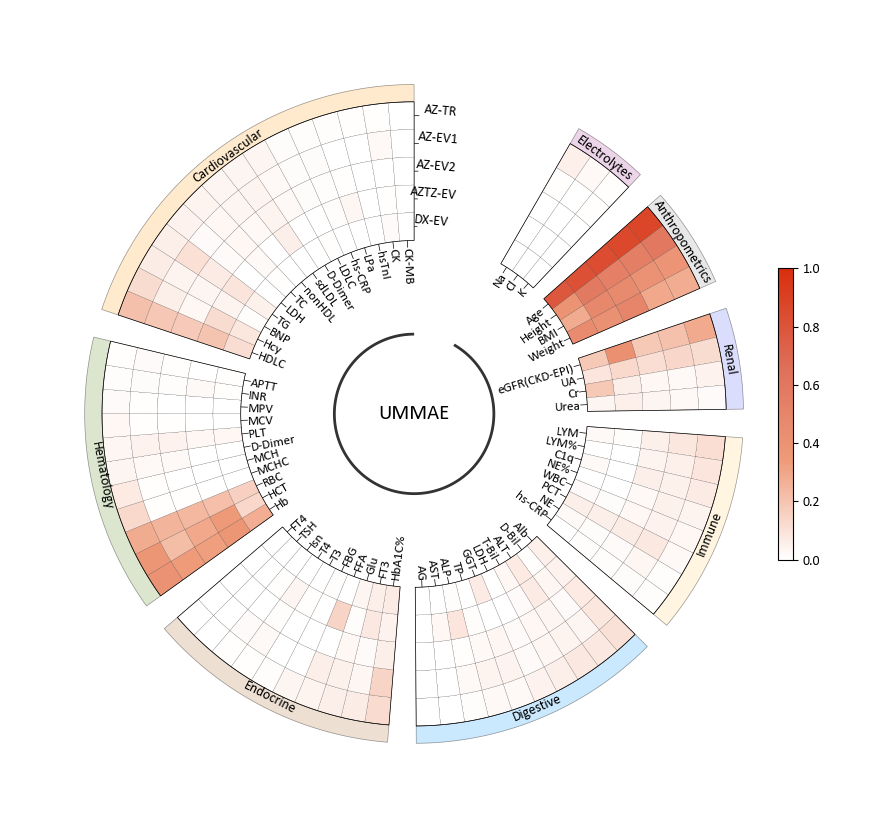

In [9]:
from pycirclize import Circos

import matplotlib.colors as mcolors

Ummae_res = metrics_qt_df_system.query("Model == 'Ummae'").pivot(
    index=["Label", "System"], columns="Center", values="R2"
)
cmap3 = mcolors.LinearSegmentedColormap.from_list(
    "my_colormap3",
    colors=[
        "white",
        "#ef9c7b",
        "#de6e58",
        "#d92e0d",
    ],
)

sectors = {k: len(v) for k, v in System_traits_map_ordered.items()}

circos = Circos(sectors, space=5, start=30, end=360, endspace=False)
vmax = 1
vmin = 0


circos.text(f"UMMAE", size=15)
circos.line(r=23, color="black", lw=2, alpha=0.8)
for i, (sector, (name, traits)) in enumerate(
    zip(circos.sectors, System_traits_map_ordered.items())
):
    start_col = 50
    df = (
        Ummae_res.query("System == @name")
        .reset_index(drop=False)
        .copy()
        .sort_values("AZ-TR", ascending=False)
    )
    plt_data = df.drop(columns=["System"]).set_index("Label").T.fillna(0)
    plt_data = plt_data.loc[centers]

    track = sector.add_track((start_col, start_col + 40))
    track.axis()
    if i + 1 == len(sectors):
        track.yticks(
            [4.5, 3.5, 2.5, 1.5, 0.5],
            plt_data.index.tolist(),
            label_size=10,
            vmin=0,
            vmax=5,
            label_margin=4,
        )

    # clip all data
    plt_data[plt_data >= vmax] = vmax

    # heatmap
    track.heatmap(
        plt_data,
        vmin=vmin,
        vmax=vmax,
        cmap=cmap3,
        rect_kws=dict(ec="black", lw=0.1),
        text_kws=dict(size=4),
        show_value=False,
    )

    # add text
    # pos_list = np.array(list(range(0, plt_data.shape[1]))) + 0.5
    pos_list = np.linspace(1, int(track.size), plt_data.shape[1]) - 0.5
    labels = plt_data.columns.tolist()
    track.xticks(
        pos_list,
        labels,
        label_margin=0,
        label_size=9.5,
        label_orientation="vertical",
        outer=False,
    )
    # )
    # add bar with text
    track_label = sector.add_track((start_col + 40, start_col + 45))
    track_label.axis(fc=system_color[sector.name], alpha=0.4)
    track_label.text(sector.name, color="black", size=10, r=start_col + 40)

circos.colorbar(
    bounds=(1, 0.3, 0.02, 0.4), vmin=vmin, vmax=vmax, orientation="vertical", cmap=cmap3
)
fig = circos.plotfig()

save_fig(fig, Figure2Dir / "Figure2a", dpi=600)

#### figure 2b 

In [10]:
Ummae_res = (
    metrics_qt_df_system.query("Model == 'Ummae'")  # only ummae
    .query("p_adj < 0.05")  # query p_adj < 0.05
    .pivot(index=["Label", "System"], columns="Center", values="R2")
)


# generate label


def assign_label(x):
    if x["AZ-TR"] > 0.1:
        if sum(x[[col for col in centers if col not in ["AZ-TR"]]] > 0.1) >= 1:
            return "VHAB"
        else:
            return "HAB"
    return "LAB"
    # else:
    # return "LAB"


Ummae_res_labeled = Ummae_res.assign(LabelType=Ummae_res.apply(assign_label, axis=1))
Ummae_res_labeled
to_count = Ummae_res_labeled[["LabelType"]].reset_index(drop=False)
to_count["LabelType"] = pd.Categorical(
    to_count["LabelType"], categories=["VHAB", "HAB", "LAB"], ordered=True
)
to_count["LabelType"].replace(
    {
        "VHAB": "R2 > 0.1 with internal and at least one external replicated",
        "HAB": "R2 > 0.1 with internal",
        "LAB": "R2 < 0.1 with internal",
    },
    inplace=True,
)
predictable_well_labels = to_count.query(
    "LabelType == 'R2 > 0.1 with internal and at least one external replicated'"
)["Label"].tolist()
predictable_well_labels

['Age',
 'BMI',
 'HCT',
 'HDLC',
 'Hb',
 'HbA1C%',
 'Hcy',
 'Height',
 'RBC',
 'UA',
 'Weight',
 'eGFR(CKD-EPI)']

/tmp/ipykernel_1872625/1992658498.py:31: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

/tmp/ipykernel_1872625/1992658498.py:31: UserWarning: 
The palette list has fewer values (8) than needed (12) and will cycle, which may produce an uninterpretable plot.


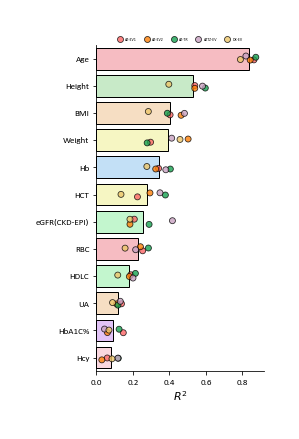

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

top_ummae_label_df = metrics_qt_df.query(
    "Model == 'Ummae' and Label in @predictable_well_labels",
)

# set order
order = (
    top_ummae_label_df.groupby("Label")["R2"]
    .mean()
    .sort_values(ascending=False)
    .index.tolist()
)

order


center_color_dict = {
    "AZ-TR": "#16A150",
    "AZ-EV1": "#FC6666",
    "AZ-EV2": "#FD8008",
    "DX-EV": "#EDC66A",
    "AZTZ-EV": "#C9A1C1",
}
# sns.barplot(data=top_ummae_label_df,x='Label',y='R2',hue='Label', palette = 'tab20',ci=None)

fig, ax = plt.subplots(figsize=(3, 6))

# 柱状图（按你的顺序和配色）
sns.barplot(
    data=top_ummae_label_df,
    y="Label",
    x="R2",
    hue="Label",
    # order=['Ummae', 'Age', 'Sex', 'Height', 'Weight', 'BMI'],
    order=order,
    # palette=relative_plot_palette,
    palette=[
        "#FFB3BA",  # 浅粉
        "#FFDFBA",  # 奶油橙
        "#FFFFBA",  # 淡黄
        "#BAFFC9",  # 薄荷绿
        "#BAE1FF",  # 浅蓝
        "#E2BAFF",  # 淡紫
        "#FFD1DC",  # 樱花粉
        "#C2F0C2",  # 淡绿
    ],
    ci=None,  # 或 'se'，论文中常见标准差
    ax=ax,
    width=0.8,
    edgecolor="black",
    lw=1,
    legend=False,
)
sns.stripplot(
    data=top_ummae_label_df,
    y="Label",
    x="R2",
    hue="Center",
    ax=ax,
    dodge=False,
    order=order,
    palette=center_color_dict,
    # hue_order=order,
    # ax=ax,
    size=6,
    edgecolor="k",  # 可选：加边框
    linewidth=0.8,
    alpha=0.8,
    legend=True,
)

# Cell/Science 风格细化
# ax.set_ylim(0, 0.45)
ax.set_ylabel("")
ax.set_xlabel("R2", fontsize=11, fontweight="bold")

# 去掉图框的顶部和右侧
sns.despine(ax=ax)

# 坐标轴刻度更细、更紧凑
ax.tick_params(axis="y", labelsize=9, rotation=0)
plt.setp(ax.get_yticklabels(), ha="right")
ax.tick_params(axis="x", labelsize=9)

ax.legend(
    loc="lower center",
    bbox_to_anchor=(0.5, 1),
    ncol=5,
    fontsize=4,
)
ax.set_xlabel(r"$R^2$")
plt.show()
# save_fig(fig, Figure2Dir / "Fig2_predictable", dpi=default_dpi)
# save_fig(fig, Figure2Dir / "Fig2_Topk", dpi=default_dpi)
save_fig(fig, Figure2Dir / "Figure2B", dpi=default_dpi)

#### Figure 2c-j

/tmp/ipykernel_1872625/3530102749.py:92: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_1872625/3530102749.py:92: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_1872625/3530102749.py:92: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_1872625/3530102749.py:92: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


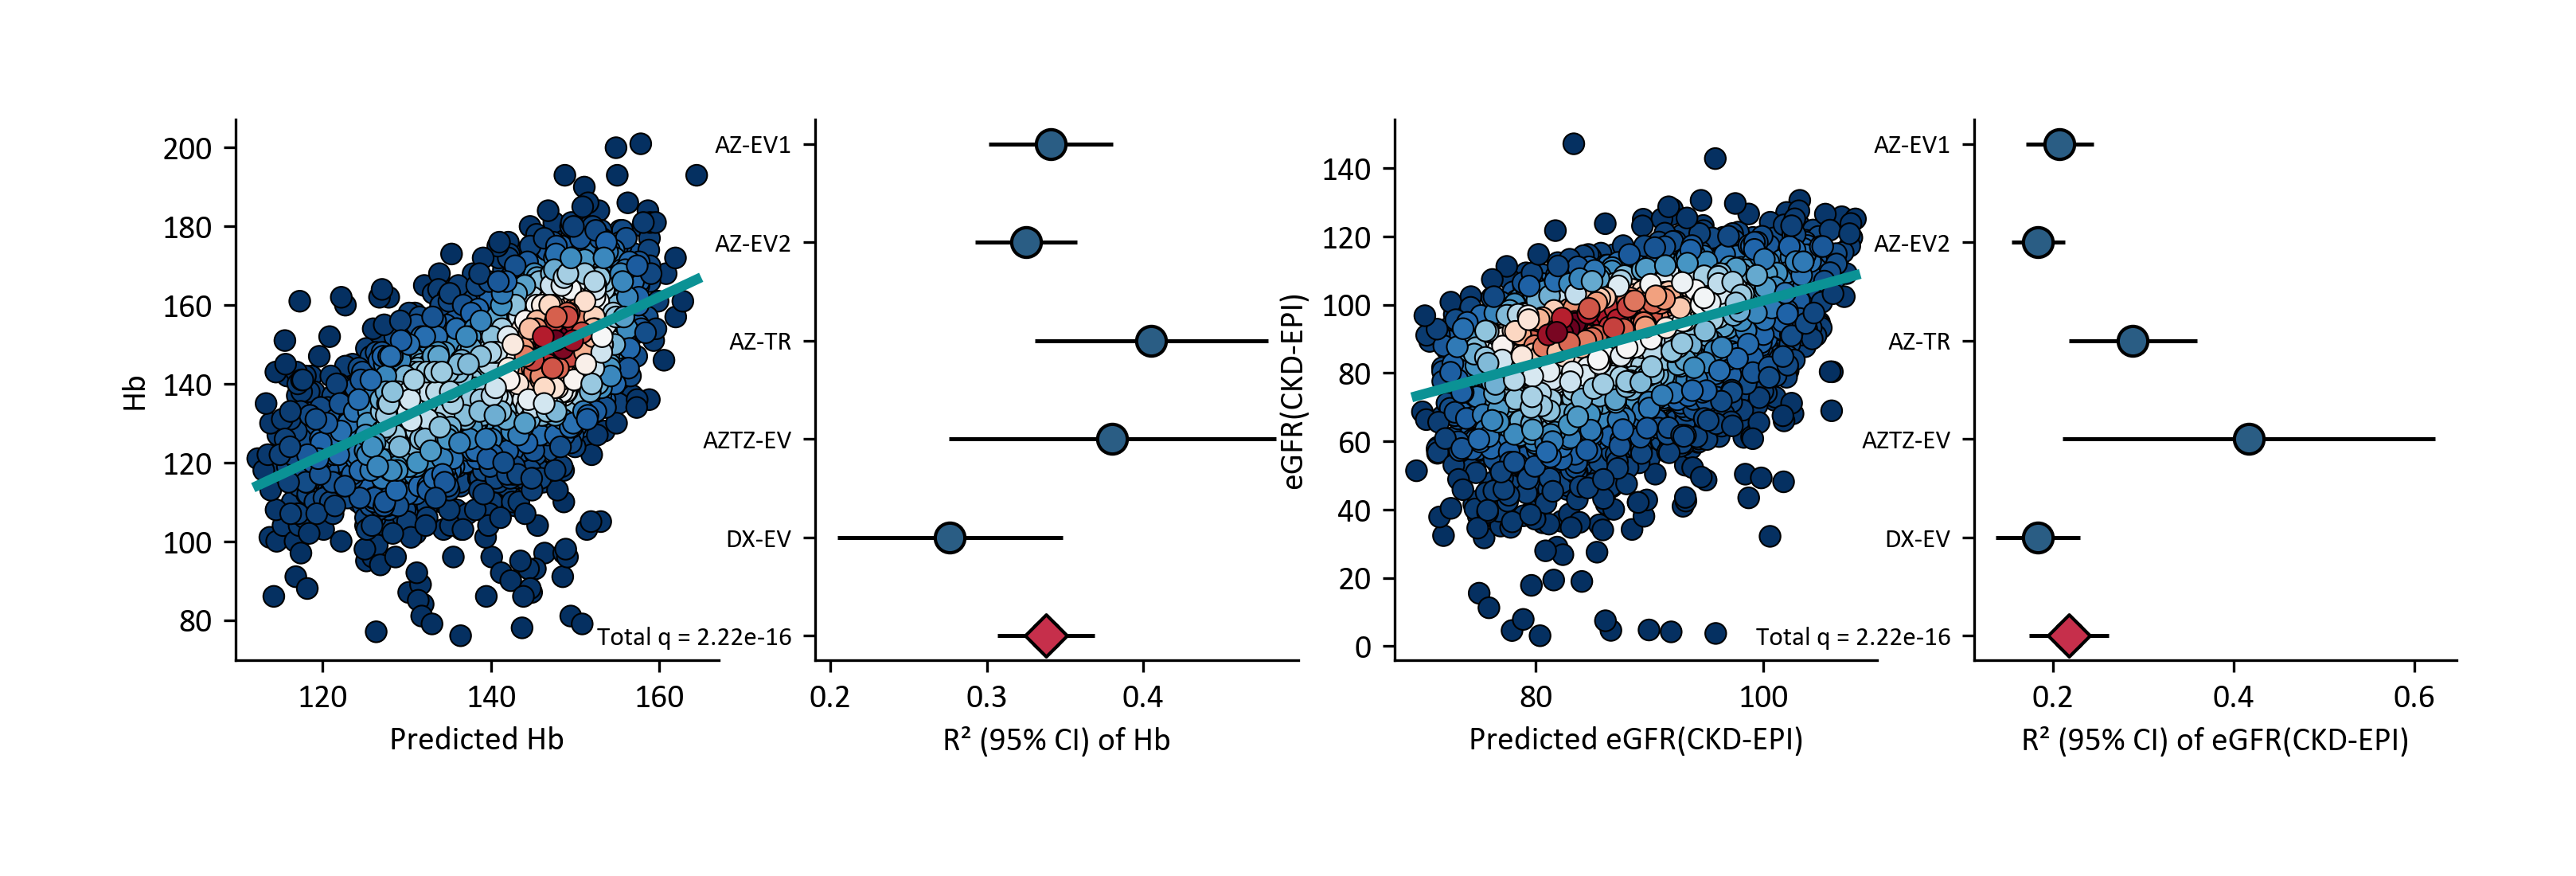

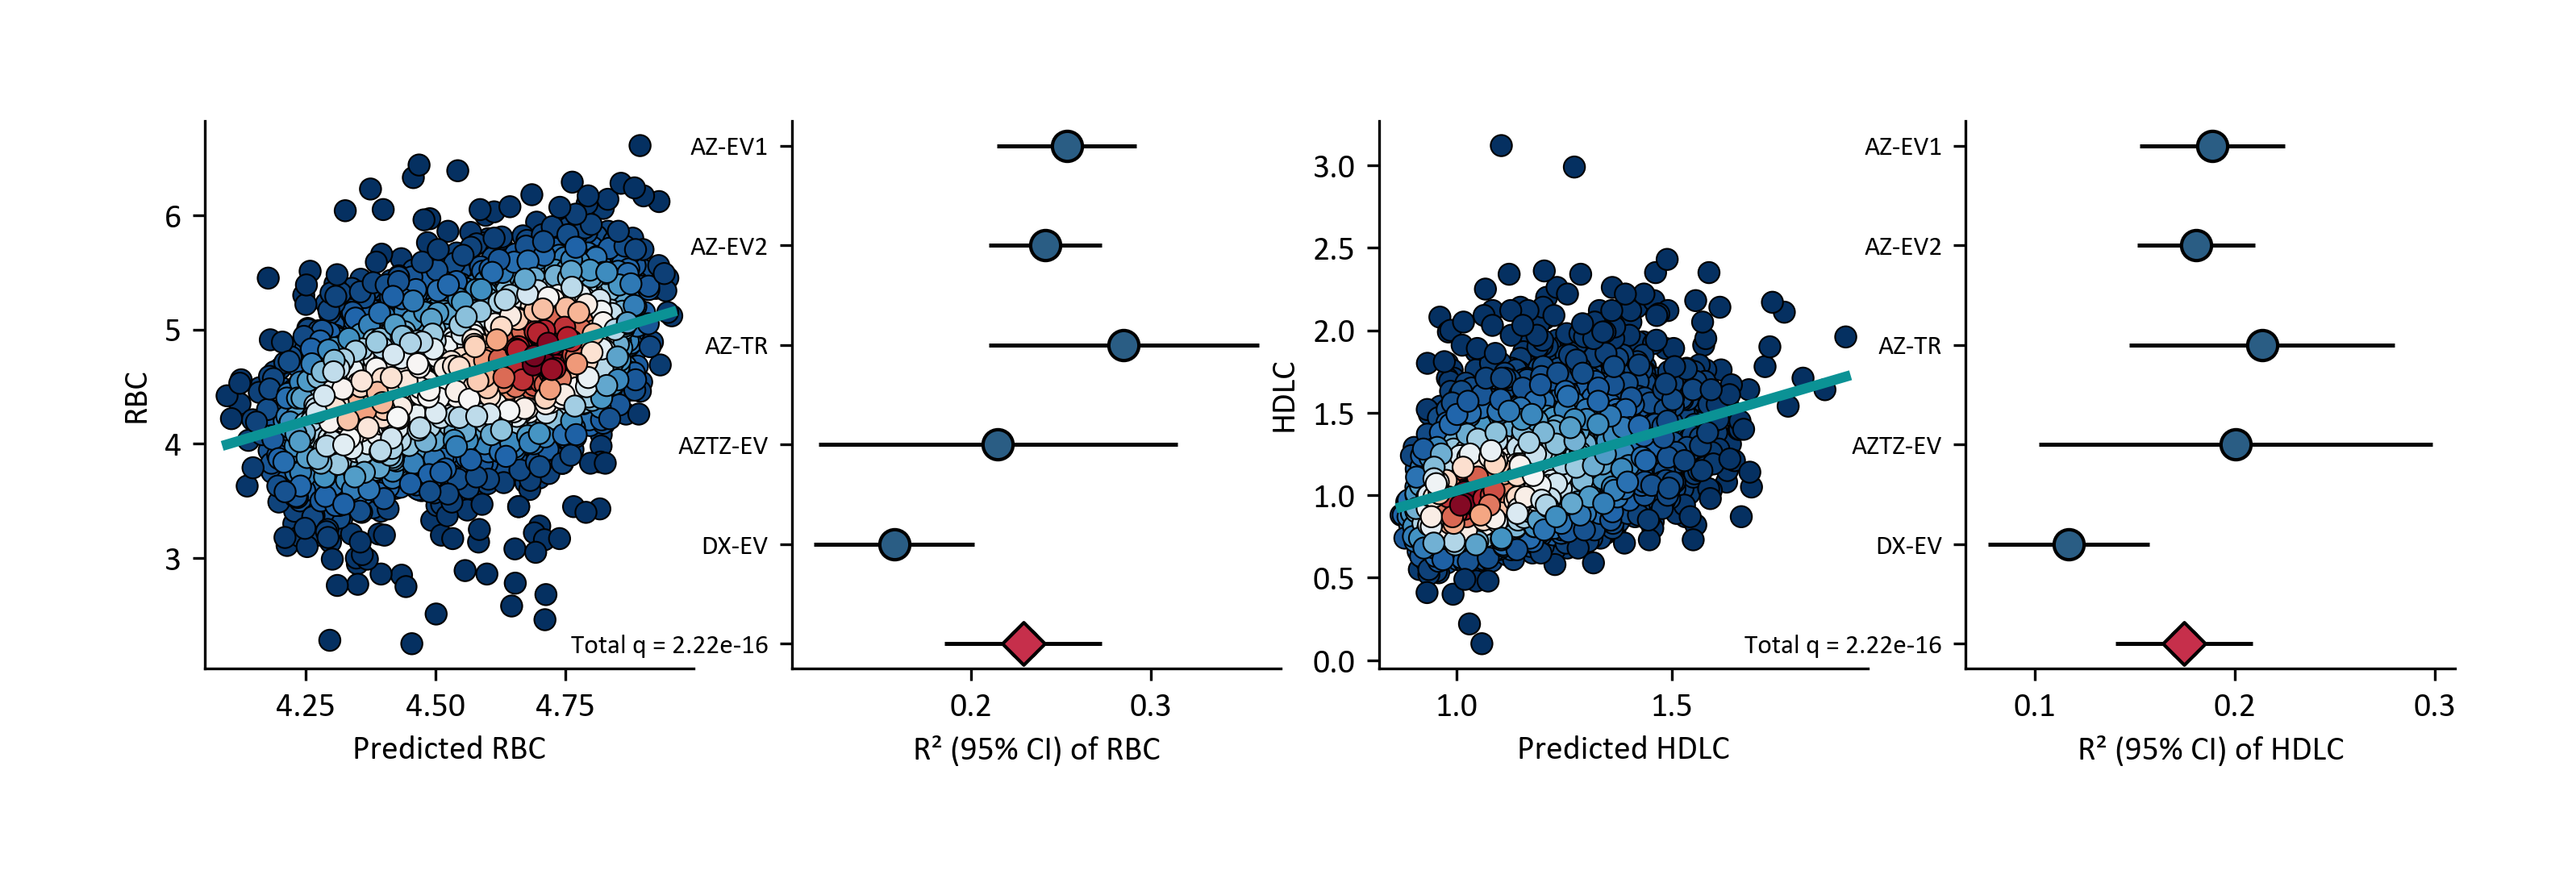

In [13]:
all_combines = [
    ["Hb", "eGFR(CKD-EPI)"],
    ["RBC", "HDLC"],
]


for tgt_list in all_combines:
    fig, axes = plt.subplots(1, 4, figsize=(12, 3), dpi=300)

    tgt = tgt_list[0]
    ax = axes[0]

    plot_corr_v2(
        Ummae_mean.query("type not in ['train', 'validation']"),
        y=tgt,
        x=f"{tgt}_Ummae",
        lineType="linear",
        # cmap=cmap3,
        # cmap="Greens",
        cmap="RdBu_r",
        ax=ax,
        cbar_show=False,
        line_kw=dict(
            line_kws={"lw": 3, "color": "#0b9295", "alpha": 1, "linestyle": "-"}
        ),
        scatter_kw={
            "s": 40,
            "edgecolor": "black",
            "linewidth": 0.5,
        },
    )
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    # ax.set_title(f"{center}-{tgt}")
    ax.set_xlabel(f"Predicted {tgt}")
    ax.set_ylabel(f"{tgt}")

    tgt_model = "Ummae"
    tgt_trait = tgt_list[0]

    test_df = metrics_qt_df.query(
        f"Model =='{tgt_model}' and Label == '{tgt_trait}'"
    ).copy()

    res = run_meta_analysis(
        test_df,
        estimate="R2",
        estimate_ci_tuple=("R2_LCI", "R2_UCI"),
    )

    meta_res = pd.DataFrame(
        {
            "Study": test_df["Center"].values.tolist()
            + [f"Total q = {res['p-value'].values[0]:.2e}"],
            "R2": test_df["R2"].values.tolist() + [res["estimate"].values[0]],
            "R2_LCI": test_df["R2_LCI"].values.tolist() + [res["ci_0.025"].values[0]],
            "R2_UCI": test_df["R2_UCI"].values.tolist() + [res["ci_0.975"].values[0]],
        }
    )
    ax = axes[1]
    plot_forest_estimate(
        meta_res,
        study="Study",
        estimate="R2",
        ci_lower="R2_LCI",
        ci_upper="R2_UCI",
        title="Meta-analysis of R² Estimates",
        ax=ax,
        scatter_kwargs={"s": 80, "edgecolor": "black", "linewidth": 1},
    )
    # ax.set_xlim(0, 0.3)
    # ax.axvline(x=0, color="black", linestyle="--", linewidth=1)0
    ax.set_title("")
    ax.set_xlabel(f"R² (95% CI) of {tgt_trait}")

    ####

    tgt = tgt_list[1]
    ax = axes[2]

    plot_corr_v2(
        Ummae_mean.query("type not in ['train', 'validation']"),
        y=tgt,
        x=f"{tgt}_Ummae",
        lineType="linear",
        # cmap=cmap3,
        # cmap="Greens",
        cmap="RdBu_r",
        ax=ax,
        cbar_show=False,
        line_kw=dict(
            line_kws={"lw": 3, "color": "#0b9295", "alpha": 1, "linestyle": "-"}
        ),
        scatter_kw={
            "s": 40,
            "edgecolor": "black",
            "linewidth": 0.5,
        },
    )
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    # ax.set_title(f"{center}-{tgt}")
    ax.set_xlabel(f"Predicted {tgt}")
    ax.set_ylabel(f"{tgt}")

    tgt_model = "Ummae"
    tgt_trait = tgt_list[1]

    test_df = metrics_qt_df.query(
        f"Model =='{tgt_model}' and Label == '{tgt_trait}'"
    ).copy()

    res = run_meta_analysis(
        test_df,
        estimate="R2",
        estimate_ci_tuple=("R2_LCI", "R2_UCI"),
    )

    meta_res = pd.DataFrame(
        {
            "Study": test_df["Center"].values.tolist()
            + [f"Total q = {res['p-value'].values[0]:.2e}"],
            "R2": test_df["R2"].values.tolist() + [res["estimate"].values[0]],
            "R2_LCI": test_df["R2_LCI"].values.tolist() + [res["ci_0.025"].values[0]],
            "R2_UCI": test_df["R2_UCI"].values.tolist() + [res["ci_0.975"].values[0]],
        }
    )
    ax = axes[3]
    plot_forest_estimate(
        meta_res,
        study="Study",
        estimate="R2",
        ci_lower="R2_LCI",
        ci_upper="R2_UCI",
        title="Meta-analysis of R² Estimates",
        ax=ax,
        scatter_kwargs={"s": 80, "edgecolor": "black", "linewidth": 1},
    )
    # ax.set_xlim(0, 0.3)
    # ax.axvline(x=0, color="black", linestyle="--", linewidth=1)0
    ax.set_title("")
    ax.set_xlabel(f"R² (95% CI) of {tgt_trait}")

    save_fig(fig, Figure2Dir / f"{tgt_list[0]}_{tgt_list[1]}", dpi=default_dpi)

## Supplementary Figure 3

#### Supplementary Figure 3a

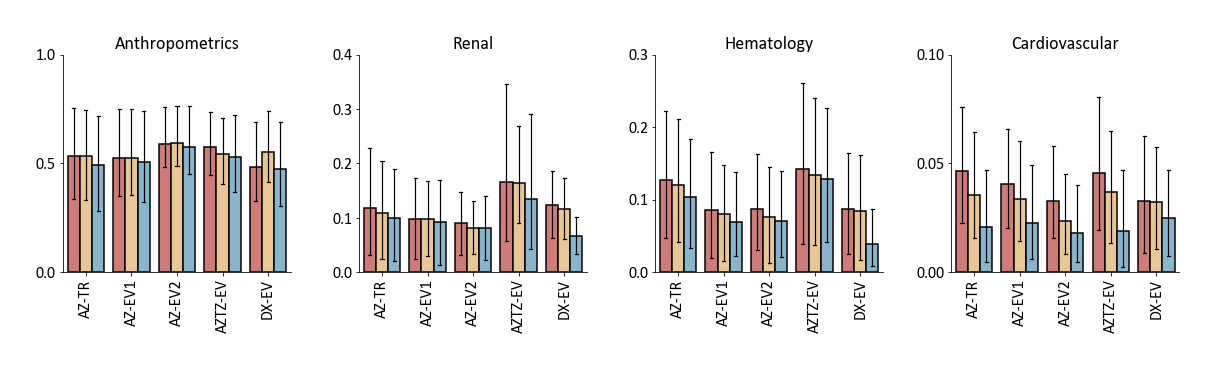

In [16]:
metrics_qt_df_system["Model"] = pd.Categorical(
    metrics_qt_df_system["Model"], models, ordered=True
)
drop_systems = ["Endocrine", "Digestive", "Immune", "Electrolytes"]
# drop_systems = []
plt_data = metrics_qt_df_system.copy().query("System not in @drop_systems")


system_order = (
    plt_data.groupby("System")["R2"].mean().sort_values(ascending=False).index.tolist()
)
plt_data["System"] = pd.Categorical(plt_data["System"], system_order, ordered=True)
col_numbers = plt_data["System"].nunique()


width_ratios = [
    subdata["Center"].nunique() for _, subdata in plt_data.groupby("System")
]
fig, axes = plt.subplots(
    1,
    plt_data["System"].nunique(),
    # figsize=(sum(width_ratios) * 0.6, 4),
    figsize=(20, 4),
    sharey=False,
    gridspec_kw={"width_ratios": width_ratios, "wspace": 0.3},
)

for i, (system, system_df) in enumerate(plt_data.groupby("System")):

    # system_df = system_df.query("N > 30")
    ax = axes[i]
    # set order of x
    order = models
    ax = sns.barplot(
        x="Center",
        y="R2",
        data=system_df,
        ax=ax,
        # palette="Blues_d",
        # order=system_df["Label"],
        order=centers,
        hue="Model",
        hue_order=order,
        edgecolor="black",
        capsize=0.2,
        err_kws={"linewidth": 1.2, "color": "black"},
        lw=1.5,
        # hue_order = hue_pallete_dict.keys(),
        palette=hue_pallete_dict,
    )
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_title(system, fontsize=18)

    ax.legend().set_visible(False)
    plt.setp(ax.get_xticklabels(), rotation=90, fontsize=16)
    plt.setp(ax.get_yticklabels(), fontsize=16)

    lowerlim, uplim = ax.get_ylim()
    yticks = nice_ticks(0, uplim, 5)
    ax.set_yticks(yticks)

save_fig(fig, SuppFigure3Dir / "SuppFig3A_part1", dpi=default_dpi)
# legend

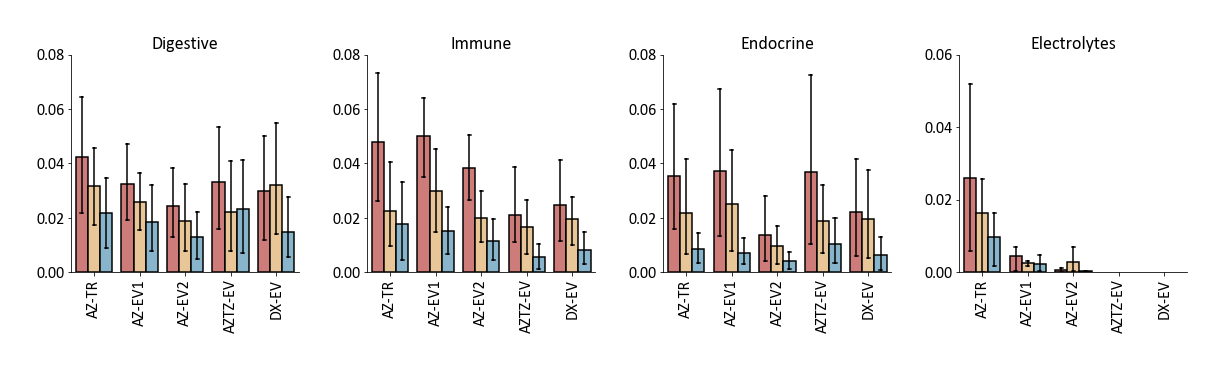

In [17]:
metrics_qt_df_system["Model"] = pd.Categorical(
    metrics_qt_df_system["Model"], models, ordered=True
)
drop_systems = [
    "Anthropometrics",
    "Hematology",
    "Renal",
    "Cardiovascular",
]
# drop_systems = []
plt_data = metrics_qt_df_system.copy().query("System not in @drop_systems")


system_order = (
    plt_data.groupby("System")["R2"].mean().sort_values(ascending=False).index.tolist()
)
plt_data["System"] = pd.Categorical(plt_data["System"], system_order, ordered=True)
col_numbers = plt_data["System"].nunique()


width_ratios = [
    subdata["Center"].nunique() for _, subdata in plt_data.groupby("System")
]
fig, axes = plt.subplots(
    1,
    plt_data["System"].nunique(),
    figsize=(20, 4),
    sharey=False,
    gridspec_kw={"wspace": 0.3},
)

for i, (system, system_df) in enumerate(plt_data.groupby("System")):

    # system_df = system_df.query("N > 30")
    ax = axes[i]
    # set order of x
    order = models

    ax = sns.barplot(
        x="Center",
        y="R2",
        data=system_df,
        order=centers,
        hue="Model",
        hue_order=order,
        edgecolor="black",
        alpha=1,
        capsize=0.2,
        err_kws={"linewidth": 1.5, "color": "black"},
        lw=1.5,
        # hue_order = hue_pallete_dict.keys(),
        palette=hue_pallete_dict,
        ax=ax,
    )
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_title(system, fontsize=18)

    ax.legend().set_visible(False)
    plt.setp(ax.get_xticklabels(), rotation=90, fontsize=16)
    plt.setp(ax.get_yticklabels(), fontsize=16)

    lowerlim, uplim = ax.get_ylim()
    yticks = nice_ticks(0, uplim, 5)
    ax.set_yticks(yticks)
save_fig(fig, SuppFigure3Dir / "SuppFig3A_part2", dpi=default_dpi)



#### Supplementary Figure 3b

In [18]:
# Extract the best model
metrics_qt_df_sota = (
    metrics_qt_df.sort_values("R2", ascending=False)
    # .query("p_adj < 0.05")
    .groupby(["Label", "Center"]).head(1)
).reset_index(drop=True)
metrics_qt_df_sota
# Calculate the ratio
metrics_qt_df_sota_count_by_center = metrics_qt_df_sota.groupby(["Center"]).apply(
    lambda x: x["Model"].value_counts().to_frame().assign(Total=len(x))
)
metrics_qt_df_sota_count_by_center["text"] = (
    metrics_qt_df_sota_count_by_center["Model"].astype(str)
    + "/"
    + metrics_qt_df_sota_count_by_center["Total"].astype(str)
)

metrics_qt_df_sota_count_by_center = metrics_qt_df_sota_count_by_center.reset_index(
    drop=False
)
metrics_qt_df_sota_count_by_center.columns = [
    "Center",
    "Model",
    "SOTA",
    "Total",
    "Text",
]
metrics_qt_df_sota_count_by_center["Center"] = pd.Categorical(
    metrics_qt_df_sota_count_by_center["Center"], centers, ordered=True
)
metrics_qt_df_sota_count_by_center["Model"] = pd.Categorical(
    metrics_qt_df_sota_count_by_center["Model"], models, ordered=True
)
metrics_qt_df_sota_count_by_center

,Center,Model,SOTA,Total,Text
0,AZ-EV1,Ummae,42,61,42/61
1,AZ-EV1,SwinLarge,16,61,16/61
2,AZ-EV1,ResNet18,3,61,3/61
3,AZ-EV2,Ummae,44,61,44/61
4,AZ-EV2,SwinLarge,11,61,11/61
5,AZ-EV2,ResNet18,6,61,6/61
6,AZ-TR,Ummae,45,62,45/62
7,AZ-TR,SwinLarge,13,62,13/62
8,AZ-TR,ResNet18,4,62,4/62
9,AZTZ-EV,Ummae,29,49,29/49


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


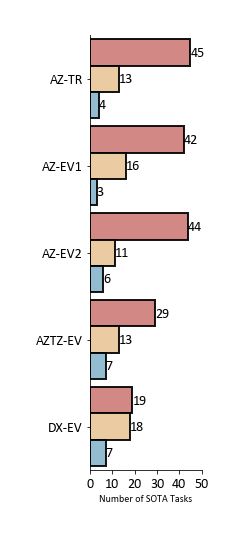

In [ ]:
# Family_color_dict = {
#     "TabPFN": "#b2182e",
#     "Lasso": "#f5b56b",
#     "XGboost": "#a37eee",
#     "MLP": "#5c9fcc",
#     "ResNet": "#d75725",
#     "TabNet": "#98d291",
#     "TabTransformer": "#02491c",
# }
plt_data = metrics_qt_df_sota_count_by_center.copy().sort_values(["Center", "Model"])

fig, ax = plt.subplots(figsize=(2, 8))
barplot = sns.barplot(
    y="Center",
    x="SOTA",
    hue="Model",
    data=plt_data,
    palette=hue_pallete_dict,
    dodge=True,
    edgecolor="black",
    alpha=0.9,
    lw=2,
    ax=ax,
    width=0.9,
)

for container in ax.containers:
    ax.bar_label(container, label_type="edge", fontsize=14)

# for bar in barplot.patches:

#     color = bar.get_facecolor()[:3]
#     # bar.set_facecolor((*color, 0.3))  # 半透明填充
#     bar.set_alpha(0.3)
#     bar.set_edgecolor(color)
# ax.legend(
#     loc="lower center",
#     bbox_to_anchor=(0.5, 1),
#     ncol=7,
#     fontsize=12,
# )
ax.legend().remove()

ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticks([0, 10, 20, 30, 40, 50])
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# ax.set_title(
#     "Number of SOTA Tasks per Center of FaceFound",
#     y=1.1,
#     fontdict=dict(fontsize=14),
# )
ax.set_title("")
ax.set_xlabel("Number of SOTA Tasks")

save_fig(fig, SuppFigure3Dir / "SuppFig3B", dpi=default_dpi)

# annotate text by the order

#### Supplementary Figure 3c-3j

/tmp/ipykernel_1872625/3530102749.py:92: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_1872625/3530102749.py:92: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_1872625/3530102749.py:92: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_1872625/3530102749.py:92: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


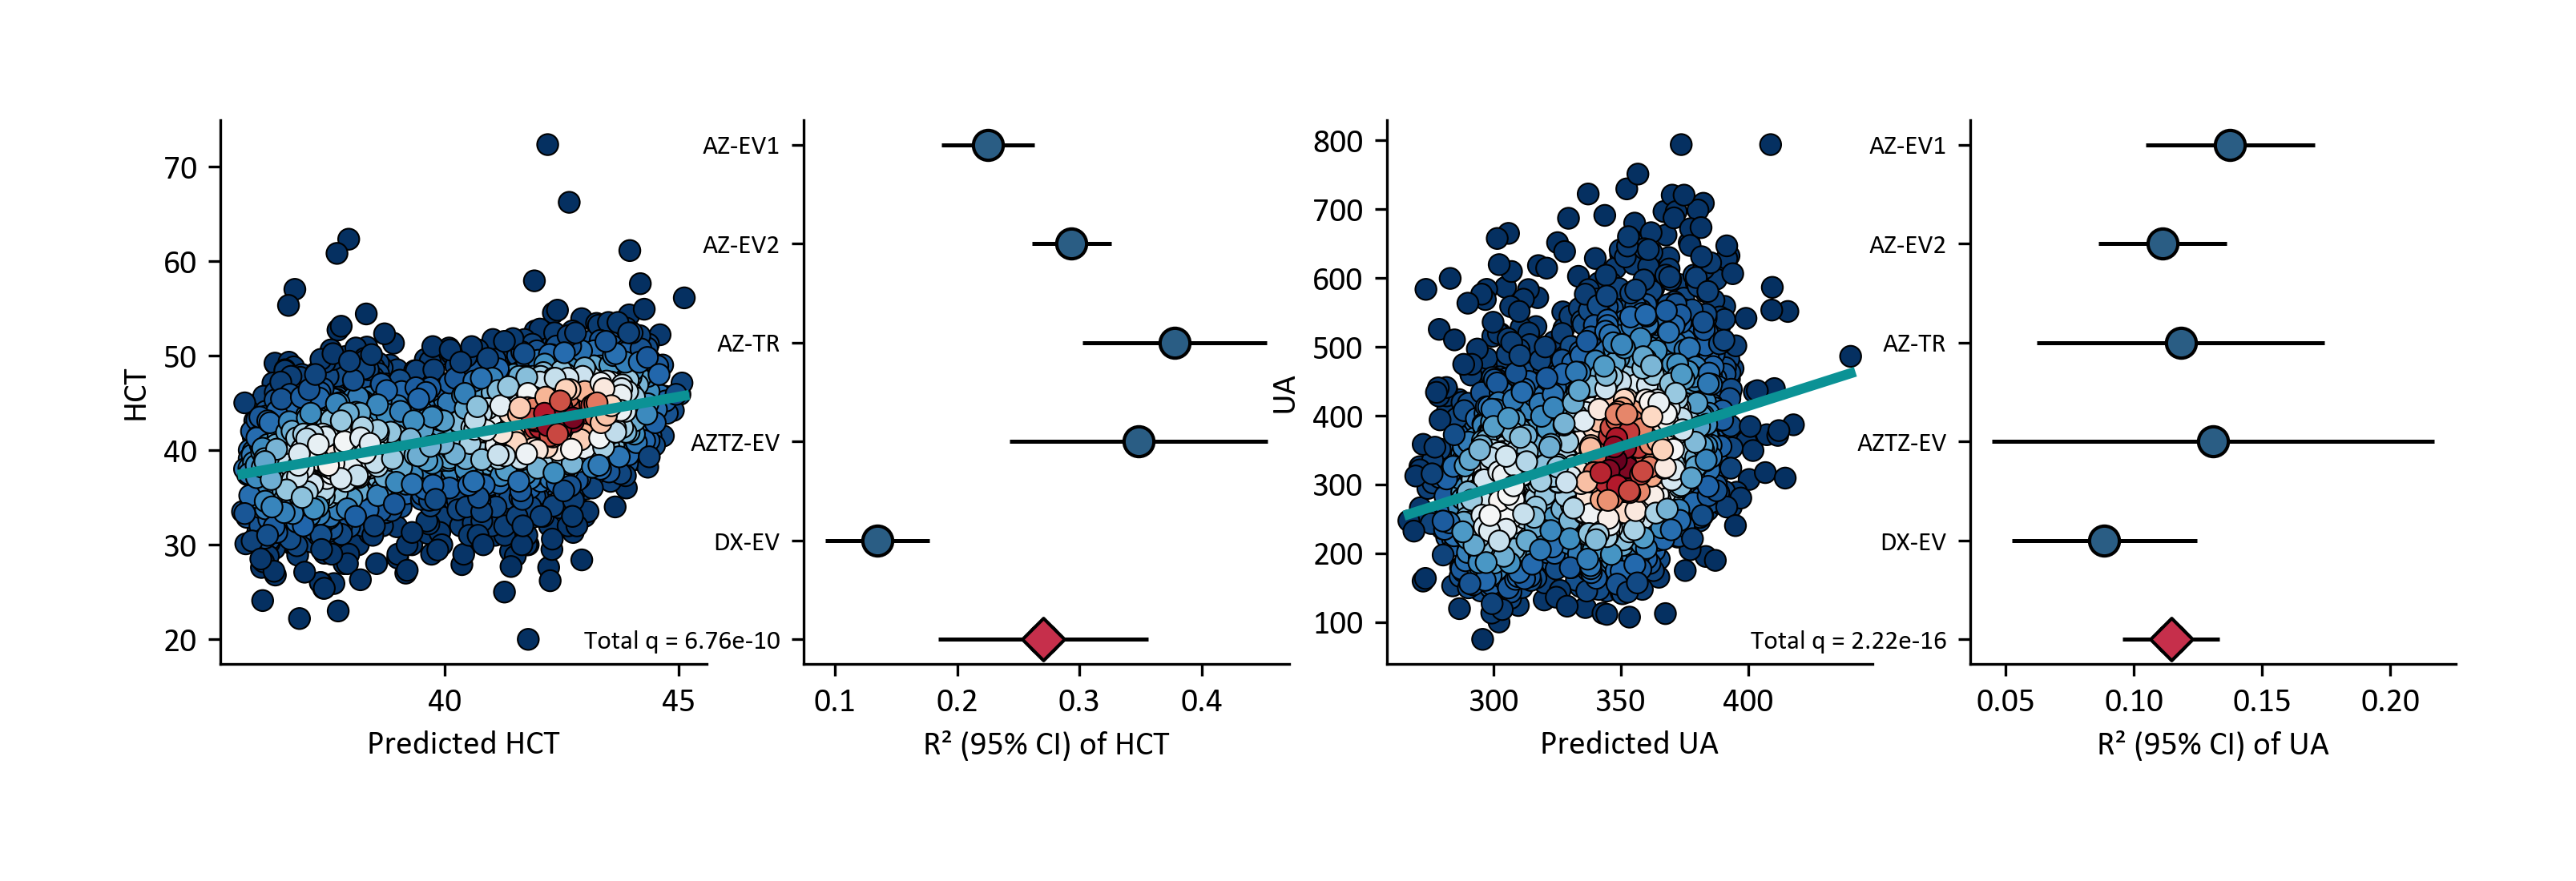

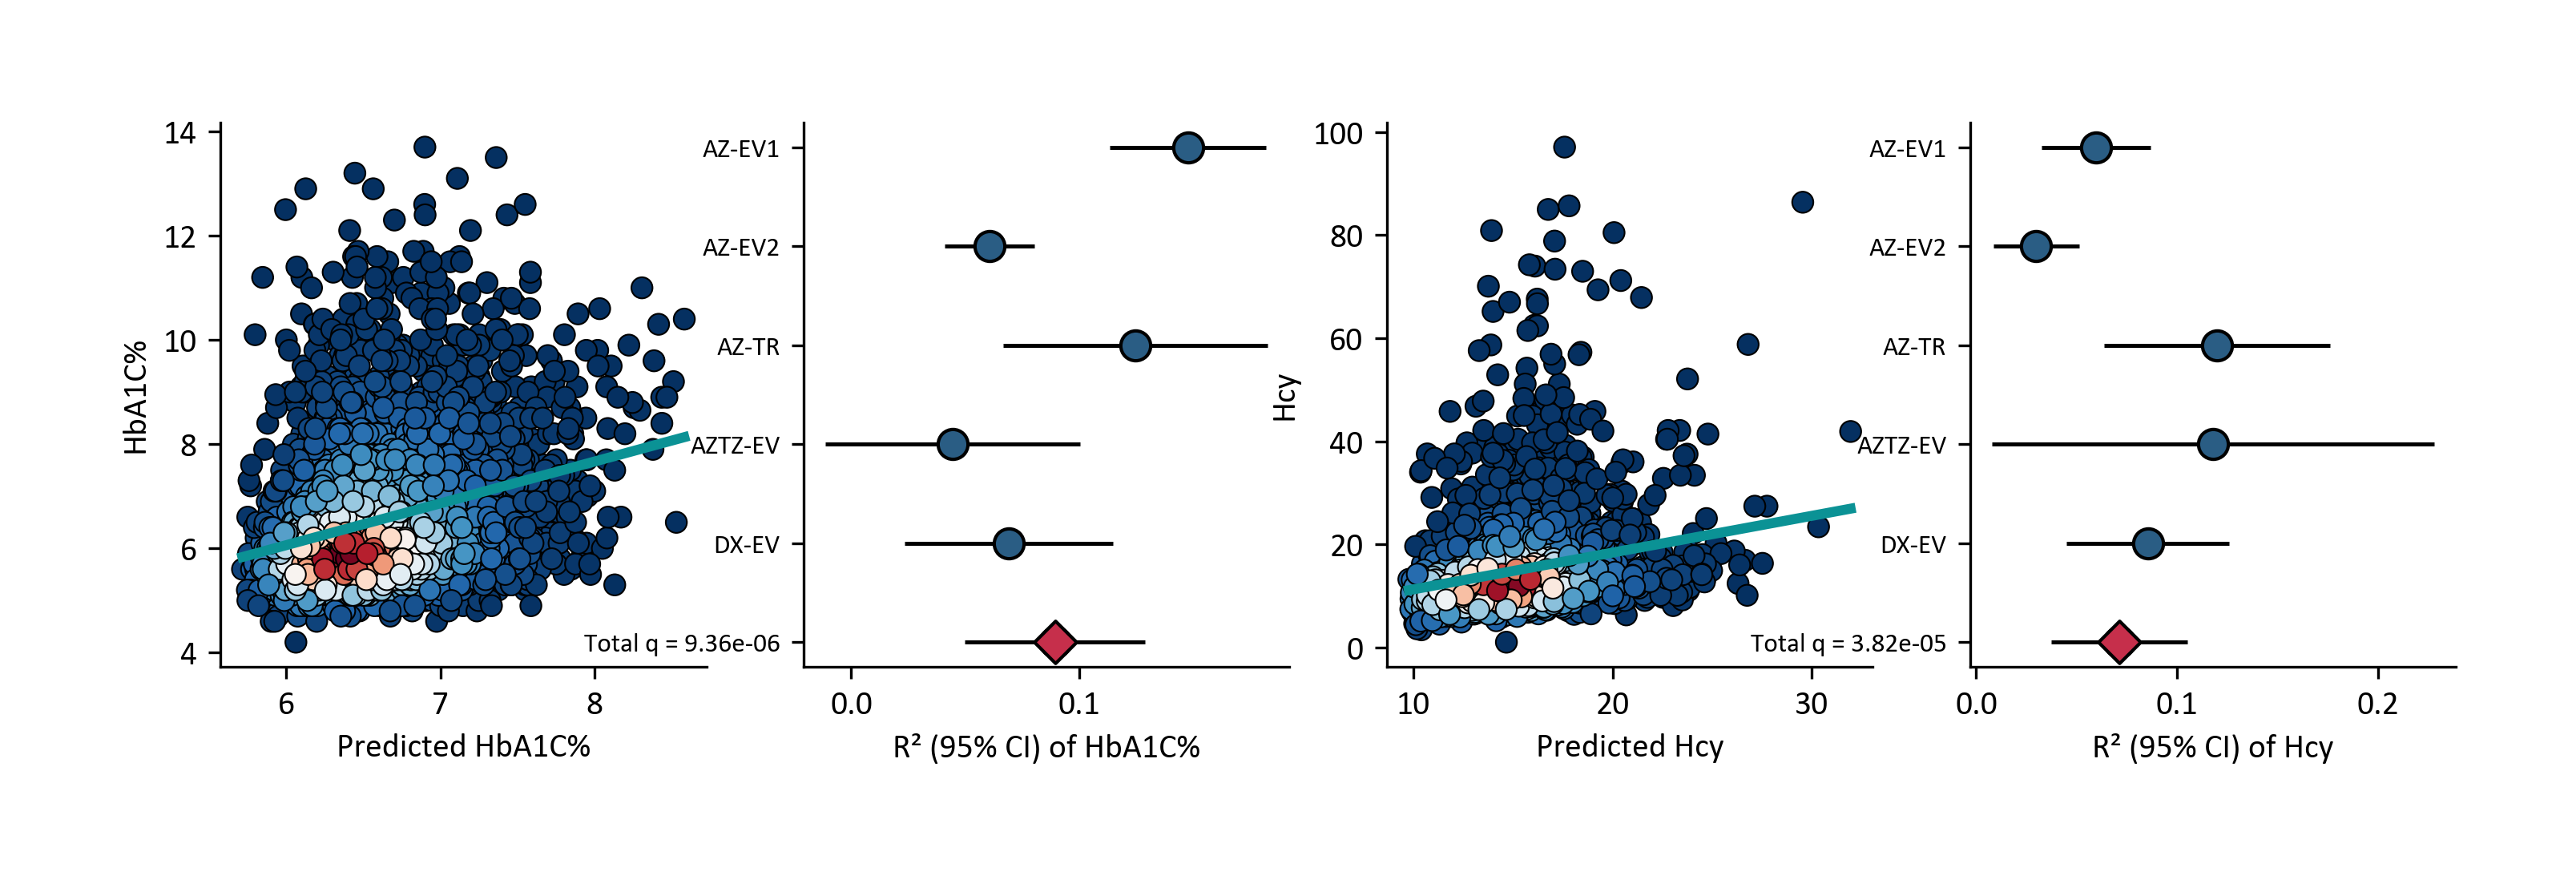

In [20]:
# load data


all_combines = [
    ("HCT", "UA"),
    ("HbA1C%", "Hcy"),
]


for tgt_list in all_combines:
    fig, axes = plt.subplots(1, 4, figsize=(12, 3), dpi=300)

    tgt = tgt_list[0]
    ax = axes[0]

    plot_corr_v2(
        Ummae_mean.query("type not in ['train', 'validation']"),
        y=tgt,
        x=f"{tgt}_Ummae",
        lineType="linear",
        # cmap=cmap3,
        # cmap="Greens",
        cmap="RdBu_r",
        ax=ax,
        cbar_show=False,
        line_kw=dict(
            line_kws={"lw": 3, "color": "#0b9295", "alpha": 1, "linestyle": "-"}
        ),
        scatter_kw={
            "s": 40,
            "edgecolor": "black",
            "linewidth": 0.5,
        },
    )
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    # ax.set_title(f"{center}-{tgt}")
    ax.set_xlabel(f"Predicted {tgt}")
    ax.set_ylabel(f"{tgt}")

    tgt_model = "Ummae"
    tgt_trait = tgt_list[0]

    test_df = metrics_qt_df.query(
        f"Model =='{tgt_model}' and Label == '{tgt_trait}'"
    ).copy()

    res = run_meta_analysis(
        test_df,
        estimate="R2",
        estimate_ci_tuple=("R2_LCI", "R2_UCI"),
    )

    meta_res = pd.DataFrame(
        {
            "Study": test_df["Center"].values.tolist()
            + [f"Total q = {res['p-value'].values[0]:.2e}"],
            "R2": test_df["R2"].values.tolist() + [res["estimate"].values[0]],
            "R2_LCI": test_df["R2_LCI"].values.tolist() + [res["ci_0.025"].values[0]],
            "R2_UCI": test_df["R2_UCI"].values.tolist() + [res["ci_0.975"].values[0]],
        }
    )
    ax = axes[1]
    plot_forest_estimate(
        meta_res,
        study="Study",
        estimate="R2",
        ci_lower="R2_LCI",
        ci_upper="R2_UCI",
        title="Meta-analysis of R² Estimates",
        ax=ax,
        scatter_kwargs={"s": 80, "edgecolor": "black", "linewidth": 1},
    )
    # ax.set_xlim(0, 0.3)
    # ax.axvline(x=0, color="black", linestyle="--", linewidth=1)0
    ax.set_title("")
    ax.set_xlabel(f"R² (95% CI) of {tgt_trait}")

    ####

    tgt = tgt_list[1]
    ax = axes[2]

    plot_corr_v2(
        Ummae_mean.query("type not in ['train', 'validation']"),
        y=tgt,
        x=f"{tgt}_Ummae",
        lineType="linear",
        # cmap=cmap3,
        # cmap="Greens",
        cmap="RdBu_r",
        ax=ax,
        cbar_show=False,
        line_kw=dict(
            line_kws={"lw": 3, "color": "#0b9295", "alpha": 1, "linestyle": "-"}
        ),
        scatter_kw={
            "s": 40,
            "edgecolor": "black",
            "linewidth": 0.5,
        },
    )
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    # ax.set_title(f"{center}-{tgt}")
    ax.set_xlabel(f"Predicted {tgt}")
    ax.set_ylabel(f"{tgt}")

    tgt_model = "Ummae"
    tgt_trait = tgt_list[1]

    test_df = metrics_qt_df.query(
        f"Model =='{tgt_model}' and Label == '{tgt_trait}'"
    ).copy()

    res = run_meta_analysis(
        test_df,
        estimate="R2",
        estimate_ci_tuple=("R2_LCI", "R2_UCI"),
    )

    meta_res = pd.DataFrame(
        {
            "Study": test_df["Center"].values.tolist()
            + [f"Total q = {res['p-value'].values[0]:.2e}"],
            "R2": test_df["R2"].values.tolist() + [res["estimate"].values[0]],
            "R2_LCI": test_df["R2_LCI"].values.tolist() + [res["ci_0.025"].values[0]],
            "R2_UCI": test_df["R2_UCI"].values.tolist() + [res["ci_0.975"].values[0]],
        }
    )
    ax = axes[3]
    plot_forest_estimate(
        meta_res,
        study="Study",
        estimate="R2",
        ci_lower="R2_LCI",
        ci_upper="R2_UCI",
        title="Meta-analysis of R² Estimates",
        ax=ax,
        scatter_kwargs={"s": 80, "edgecolor": "black", "linewidth": 1},
    )
    # ax.set_xlim(0, 0.3)
    # ax.axvline(x=0, color="black", linestyle="--", linewidth=1)0
    ax.set_title("")
    ax.set_xlabel(f"R² (95% CI) of {tgt_trait}")

    save_fig(fig, SuppFigure3Dir / f"{tgt_list[0]}_{tgt_list[1]}", dpi=default_dpi)

## Supplementary Figure 4

In [21]:
relative_plot_palette = {
    "Ummae": "#aa3583",
    "Age": "#476e86",
    "Sex": "#fcc67d",
    "Height": "#d5c1d7",
    "Weight": "#afd894",
    "BMI": "#9fdaeb",
}

In [30]:
# load basic data

adjust_r2_pvalue = pd.read_csv(RawDataDir / "adjusted_ummae_r2.csv")
adjust_r2_pvalue_simple = adjust_r2_pvalue[
    ["Label", "R2", "pearsonr", "spearmanr", "N", "p_adj"]
].rename(
    columns={"R2": "R2_adj", "pearsonr": "pearsonr_adj", "spearmanr": "spearmanr_adj"}
)
adjust_r2_pvalue_simple["Label"] = adjust_r2_pvalue_simple["Label"].replace(
    {"HbA1C%": "HbA1C"}
)
adjust_r2_pvalue_simple.set_index("Label", inplace=True)
adjust_r2_pvalue_simple

,R2_adj,pearsonr_adj,spearmanr_adj,N,p_adj
Label,,,,,
HbA1C,0.124409,0.352716,0.322341,1429,2.981030e-44
TG,0.050475,0.224667,0.106085,1450,4.937820e-17
Glu,0.035923,0.189534,0.159546,1454,3.612770e-12
Hb,0.026922,0.164079,0.163665,1451,3.457753e-09
LYM,0.022873,0.151238,0.161752,1451,6.551018e-08
HDLC,0.020782,0.144161,0.098044,1450,2.814658e-07
nonHDL,0.020095,0.141756,0.121235,1406,6.562744e-07
sdLDL,0.020076,0.141688,0.127835,1001,2.882787e-05
FFA,0.018551,0.136201,0.114612,1000,6.156390e-05


In [31]:
relative_df = pd.read_feather(RawDataDir / f"RelativeImportance_Ummae_concat.feather")
relative_df

,Method,R2.decomp,Omics,Importance,Model,Label
0,lmg,0.154974,Age,0.015674,Ummae,HbA1C
1,lmg,0.154974,Sex,0.007351,Ummae,HbA1C
2,lmg,0.154974,Height,0.007754,Ummae,HbA1C
3,lmg,0.154974,Weight,0.007991,Ummae,HbA1C
4,lmg,0.154974,BMI,0.011507,Ummae,HbA1C
...,...,...,...,...,...,...
151,lmg,0.005032,Sex,0.357499,Ummae,Na
152,lmg,0.005032,Height,0.102120,Ummae,Na
153,lmg,0.005032,Weight,0.061146,Ummae,Na
154,lmg,0.005032,BMI,0.019032,Ummae,Na


In [32]:
from pypalettes import load_cmap


def plot_stacked_bar_chart(
    data,
    x,
    y=None,
    order=None,
    hue=None,
    hue_order=None,
    sort_hue_order_by=None,
    bar_width=0.85,
    xlabel="Group",
    ylabel="Percentage (%)",
    title=None,
    colors=None,
    ax=None,
    barkwargs=None,
):
    """
    Plot a stacked bar chart.

    Parameters:
    - data: DataFrame
    - x: Column name for the x-axis (e.g., "Name").
    - hue: Column name for the stacked categorical variable (e.g., "bias"), default is None.
    - bar_width: Width of each bar, default is 0.85.
    - xlabel: Label for the x-axis, default is "Group".
    - ylabel: Label for the y-axis, default is "Percentage (%)".
    - title: Title of the chart, default is None.
    - colors: Colors for each layer, default is None (colors will be assigned automatically).


    Examples1: With Value passed

    data = {
        "Name": ["A", "B", "C", "D", "E", "F", "G"] * 3,
        "Group": ["Group1"] * 7 + ["Group2"] * 7 + ["Group3"] * 7,
        "Value": np.random.randint(1, 10, 21),
    }
    df = pd.DataFrame(data)

    plot_stacked_bar_chart(
        df,
        x="Name",
        y="Value",
        hue="Group",
        bar_width=0.85,
        xlabel="Group",
        ylabel="Percentage (%)",
        title="Stacked Bar Chart",
        colors=["#0072B2", "#E69F00", "#009E73"],
    )

    Examples2: Without value passed, will count the number of samples in each group like sns.histplot do.

    data = {
        "Name": ["A", "B", "C", "D", "E", "F", "G"] * 3,
        "Group": ["Group1"] * 7 + ["Group2"] * 7 + ["Group3"] * 7,
    }
    df = pd.DataFrame(data)

    plot_stacked_bar_chart(
        df,
        x="Name",
        hue="Group",
        bar_width=0.85,
        xlabel="Group",
        ylabel="Number of Samples",
        title="Stacked Bar Chart",
        colors=["#0072B2", "#E69F00", "#009E73"],
    )
    """

    if order is None:
        order = (
            data[x].unique() if data[x].dtype in [object, str] else data[x].categories
        )
    if hue_order is None:
        hue_order = (
            data[hue].unique()
            if data[hue].dtype in [object, str]
            else data[hue].cat.categories
        )

    if y is None:
        if hue:

            stacked_data = data.groupby([x, hue]).size().unstack(fill_value=0)
        else:

            stacked_data = data.groupby(x).size()

        totals = stacked_data.sum(axis=1)

    else:
        stacked_data = data.pivot_table(y, index=x, columns=hue)
        totals = stacked_data.sum(axis=1)

    percentages = stacked_data.div(totals, axis=0) * 100
    # percentages = percentages.merge(
    #     totals.to_frame("Total"), left_index=True, right_index=True
    # )

    percentages = percentages.loc[order]  # sort

    if sort_hue_order_by is not None:
        percentages = percentages.sort_values(sort_hue_order_by, ascending=False)

    if colors is None:
        colors = load_cmap("Lupi").colors
    elif isinstance(colors, str):
        colors = load_cmap(str).colors
    elif isinstance(colors, list):
        colors = colors[: len(hue_order)]

    if not isinstance(colors, dict):
        colors = {column: color for column, color in zip(hue_order, colors)}

    bottom = np.zeros(stacked_data.shape[0])
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    r = np.arange(percentages.shape[0])

    ## updated
    plt_barkwargs = dict(
        edgecolor="black",
        lw=0.25,
    )
    if barkwargs is not None:
        plt_barkwargs.update(barkwargs)

    for i, column in enumerate(hue_order):

        ax.bar(
            r,
            percentages[column],
            bottom=bottom,
            label=column,
            color=colors[column],
            width=bar_width,
            **plt_barkwargs
        )
        bottom += percentages[column]

    ax.set_xticks(r)
    ax.set_xticklabels(percentages.index, rotation=45, ha="right")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xlim(r[0] - 0.5, r[-1] + 0.5)

    # Ttiel
    if title:
        ax.set_title(title)

    # Set the legend
    ax.legend(loc="upper left", title=hue, bbox_to_anchor=(1, 1), frameon=False)

/tmp/ipykernel_1872625/2778991896.py:26: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


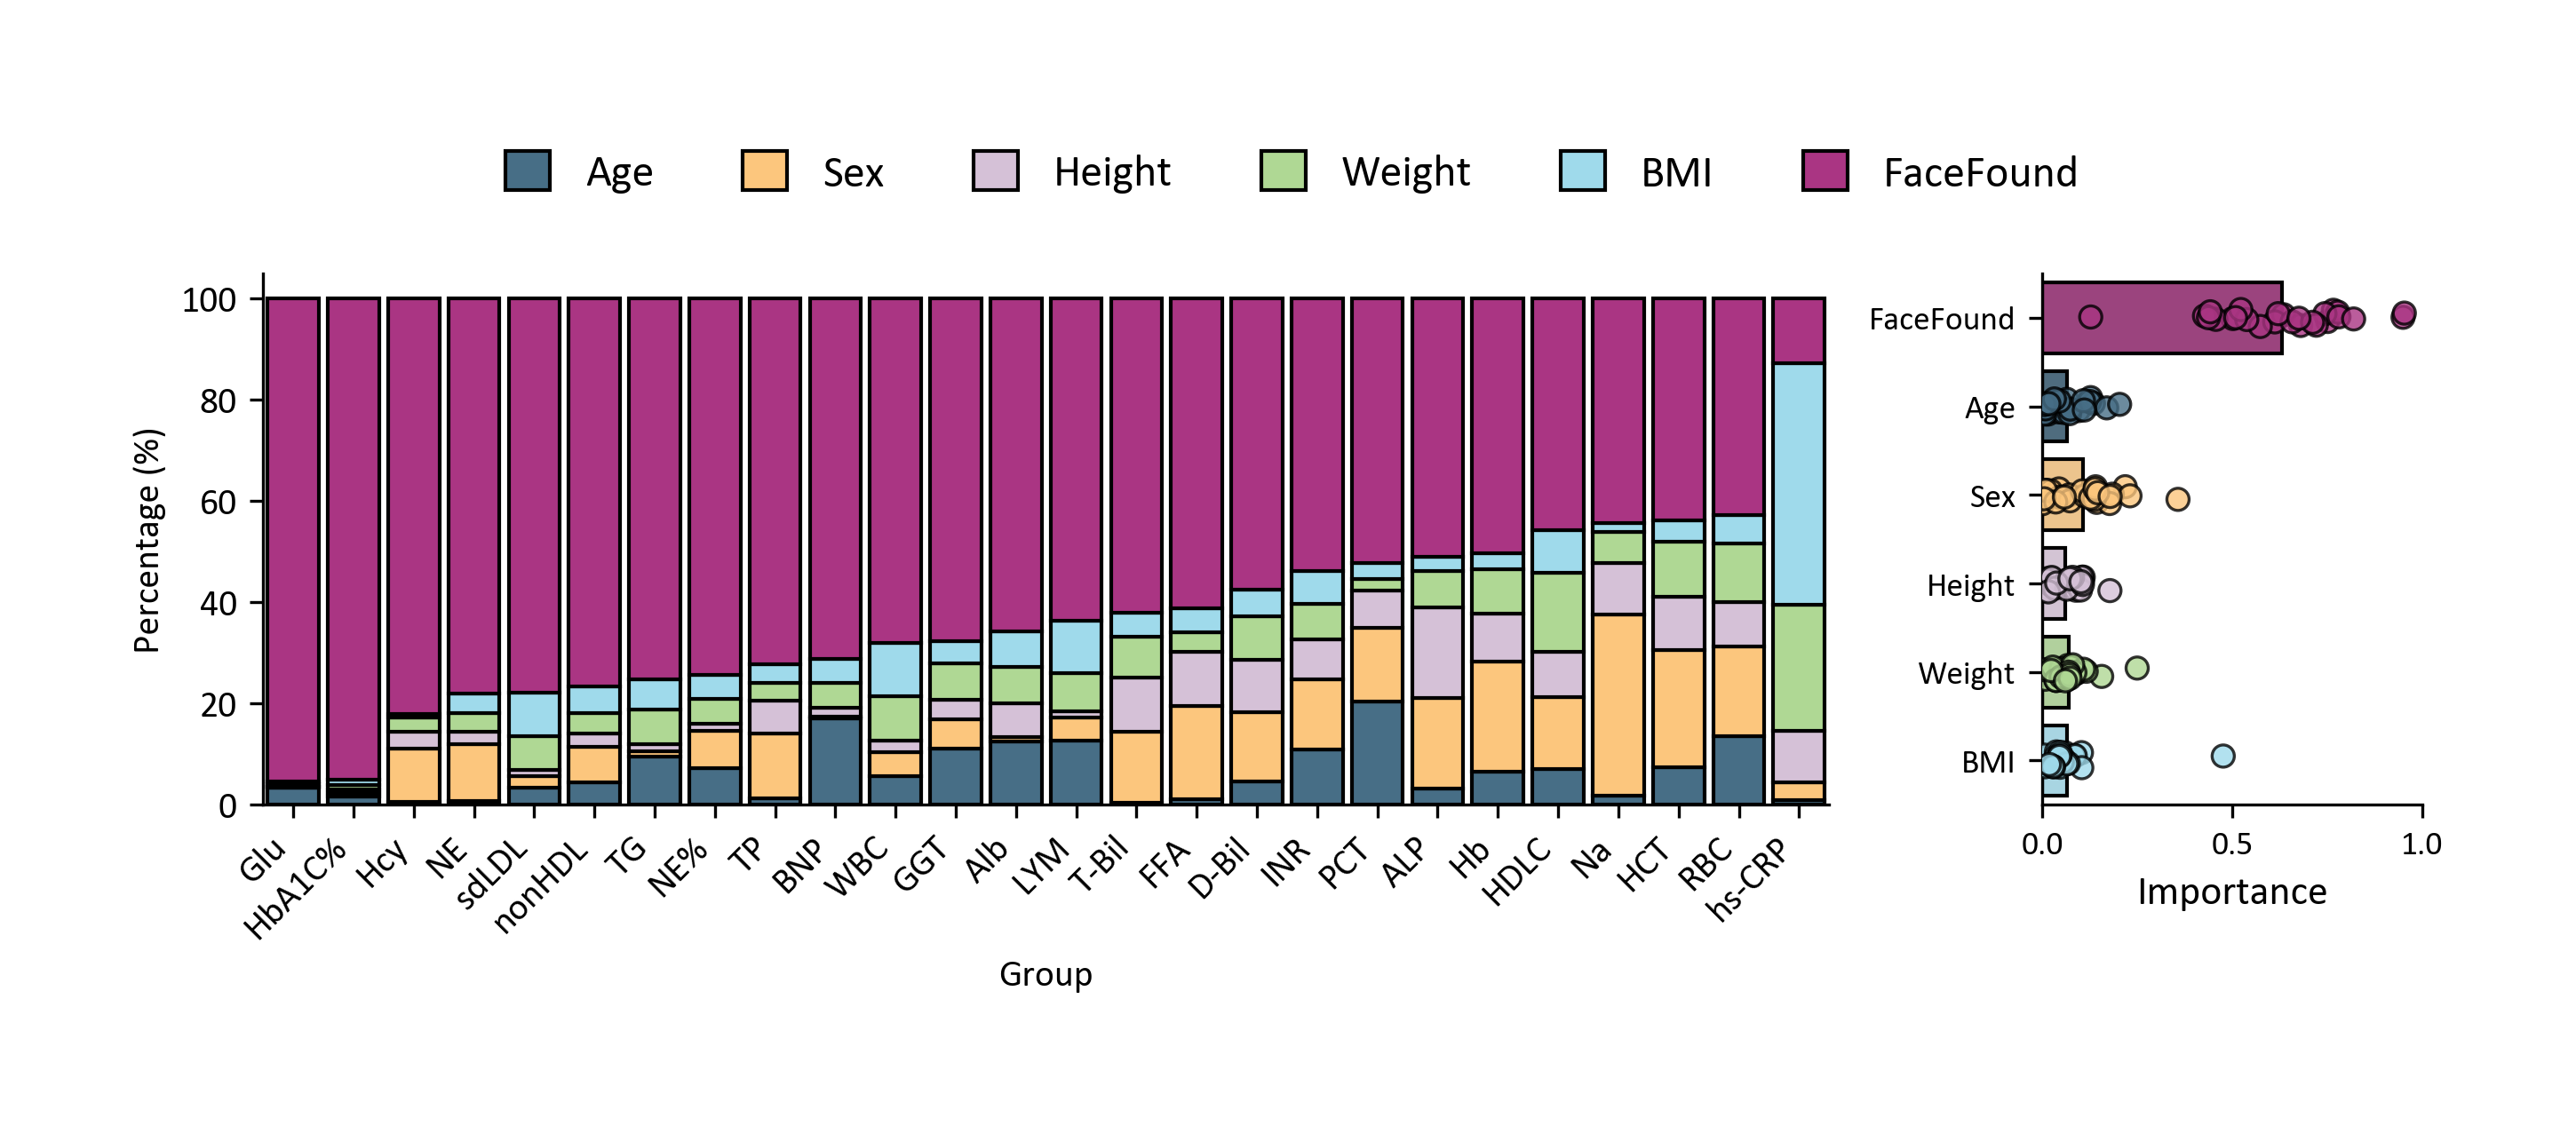

In [33]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
# GridSpec
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(9, 3), dpi=300)
gs = GridSpec(1, 4, figure=fig)
ax1 = fig.add_subplot(gs[-1])
ax2 = fig.add_subplot(gs[0:-1])

import matplotlib.pyplot as plt
import seaborn as sns

relative_plot_palette = {
    "FaceFound": "#aa3583",
    "Age": "#476e86",
    "Sex": "#fcc67d",
    "Height": "#d5c1d7",
    "Weight": "#afd894",
    "BMI": "#9fdaeb",
}
plt_data = relative_df.copy()
plt_data["Label"] = plt_data["Label"].replace({"HbA1C": "HbA1C%"})
plt_data["Omics"] = plt_data["Omics"].replace({"Ummae": "FaceFound"})
order = ["FaceFound", "Age", "Sex", "Height", "Weight", "BMI"]
# 柱状图（按你的顺序和配色）
sns.barplot(
    data=plt_data,
    y="Omics",
    x="Importance",
    hue="Omics",
    order=order,
    palette=relative_plot_palette,
    ci=None,  # 或 'se'，论文中常见标准差
    ax=ax1,
    legend=False,
    width=0.8,
    # err_kws={},
    #     capsize=0.2,
    #     err_kws={"linewidth": 1},
    edgecolor="black",
    lw=1,
)
sns.stripplot(
    data=plt_data,
    y="Omics",
    x="Importance",
    hue="Omics",
    ax=ax1,
    dodge=False,
    palette=relative_plot_palette,
    order=order,
    # hue_order=order,
    # ax=ax,
    size=6,
    edgecolor="k",  # 可选：加边框
    linewidth=0.8,
    alpha=0.8,
    legend=False,
)

# Cell/Science 风格细化
ax1.set_xlim(0, 1)
ax1.set_ylabel("")
ax1.set_xlabel("Importance", fontsize=11, fontweight="bold")

# 去掉图框的顶部和右侧
sns.despine(ax=ax1)

# 坐标轴刻度更细、更紧凑
ax1.tick_params(axis="y", labelsize=9, rotation=0)
ax1.tick_params(axis="x", labelsize=9)

# set fig legend


# ax1.legend(
#     loc="lower center",
#     bbox_to_anchor=(0.5, 0.8),
#     ncol=3,
#     fontsize=12,
# )


plot_stacked_bar_chart(
    data=plt_data,
    x="Label",
    y="Importance",
    hue="Omics",
    sort_hue_order_by=["FaceFound"],
    colors=relative_plot_palette,
    barkwargs=dict(alpha=1, edgecolor="black", lw=1),
    ax=ax2,
)
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.legend().remove()

fig.legend(
    loc="lower center",
    bbox_to_anchor=(0.5, 1),
    ncol=6,
    fontsize=12,
)
fig.tight_layout()
save_fig(fig, SuppFigure4Dir / "SuppFigure4", dpi=default_dpi)